# How to Automate SQL Database Queries with AI

### Free Generative AI Data Science Workshop

If you want to learn how to build AI Agents that perform Data Science, Business Intelligence, Churn Modeling, Time Series Forecasting, and more, [register for my next free AI for Data Scientists workshop here.](https://learn.business-science.io/ai-register)


# Table of Contents

1. [Introduction](#introduction)
2. [Load Libraries](#load-libraries)
3. [Setup AI and Logging](#setup-ai-and-logging)
4. [Connect to a SQL Database](#connect-to-a-sql-database)
5. [Create The Agent](#create-the-agent)
6. [Run the Agent](#run-the-agent)
7. [Response](#response)
    1. [SQL Query Code](#sql-query-code)
    2. [Pandas Data Frame From SQL Query](#pandas-data-frame-from-sql-query)
    3. [Python Pipeline Function](#python-pipeline-function)
    4. [Storage Location](#storage-location)
8. [Free Generative AI Data Science Workshop](#free-generative-ai-data-science-workshop)

### Load Libraries

In [1]:
# * Libraries

from langchain_openai import ChatOpenAI

import pandas as pd
import sqlalchemy as sql

import os
import yaml
from pprint import pprint

from ai_data_science_team.agents import SQLDatabaseAgent

### Setup AI and Logging

This section of code sets up the LLM inputs and the logging information. Logging is used to store AI-generated code and files during the AI Data Science Teams processing of files. 

*Important Note:* This example uses OpenAI's API. But any LLM can be used such as Anthropic or local LLMs with Ollama.

In [2]:
# * Setup

MODEL    = "gpt-4o-mini"
LOG      = True
LOG_PATH = os.path.join(os.getcwd(), "logs/")

os.environ["OPENAI_API_KEY"] = yaml.safe_load(open('../credentials.yml'))['openai']

llm = ChatOpenAI(model = MODEL)

llm


ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x7fcc113e1ae0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x7fcc20b85300>, root_client=<openai.OpenAI object at 0x7fcc113e3a60>, root_async_client=<openai.AsyncOpenAI object at 0x7fcc113e1ab0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

### Connect to a SQL Database

Next, let's connect to the leads data from a SQL database. We will need to use a `sqlalchemy` connection to use the SQL Database Agent.

In [3]:
sql_engine = sql.create_engine("sqlite:///data/northwind.db")

conn = sql_engine.connect()

conn

### Create The Agent

Run this code to create the agent with `SQLDatabaseAgent()`.

The only required parameters are `model` and `connection`. 

- `model` is the LLM model that you want to use.
- `connection` is the sqlalchemy connection to the SQL database.

Other parameters that I've included in this demo are:

- `n_samples`: The number of samples for each table x column to share with the LLM. Reduce this number for large databases to prevent LLM Max Token errors.
- `log`: Set up logging the SQL DB agent's pipeline function
- `log_path`: The directory to save the SQL DB agent's pipeline function
- `bypass_explain_code`: Dynamically bypass the explain code step in the LangGraph DAG. This is useful to speed up response time when you don't need to see the explain code.
- `bypass_recommended_steps`: Dynamically bypass the recommended steps in the LangGraph DAG. This is useful to speed up response time when you don't need to see the recommended steps.

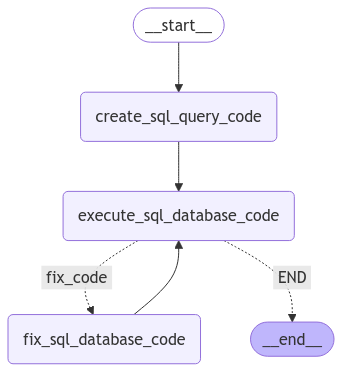

In [4]:
# Make the agent
sql_agent = SQLDatabaseAgent(
    model = llm, 
    connection=conn, 
    n_samples=1, # Needed for large databases to avoid token limits
    log=LOG, 
    log_path=LOG_PATH,
    bypass_explain_code=True,
    bypass_recommended_steps=True,
)

sql_agent

## Run the Agent

The main inputs to the SQL DB Agent are:

- **user_instructions**: What actions you'd like to take on the SQL database query. 
- **max_retries**: Used to limit the number of attempts to fix the SQL and Python code generated by the agent. Set this to 3 to limit to 3 attempts. 
- **retry_count**: Set this to 0. 

In [5]:

sql_agent.invoke(
    user_instructions="What are the sales for each product?",
    max_retries=3,
    retry_count=0,
)

---SQL DATABASE AGENT----
    * CREATE SQL QUERY CODE
    * CREATE PYTHON FUNCTION TO RUN SQL CODE
      File saved to: /Users/mdancho/Desktop/course_code/ai-data-science-team/logs/sql_database.py
    * EXECUTING AGENT CODE ON SQL CONNECTION


### Response

The response produced contains everything we need to understand the data cleaning decisions made and get the cleaned dataset. 

In [6]:
sql_agent.get_response()

{'messages': [],
 'user_instructions': 'What are the sales for each product?',
 'data_sql': {'ProductName': {0: 'Côte de Blaye',
   1: 'Thüringer Rostbratwurst',
   2: 'Mishi Kobe Niku',
   3: "Sir Rodney's Marmalade",
   4: 'Carnarvon Tigers',
   5: 'Raclette Courdavault',
   6: 'Manjimup Dried Apples',
   7: 'Tarte au sucre',
   8: 'Ipoh Coffee',
   9: 'Rössle Sauerkraut',
   10: 'Schoggi Schokolade',
   11: 'Vegie-spread',
   12: 'Northwoods Cranberry Sauce',
   13: 'Alice Mutton',
   14: 'Queso Manchego La Pastora',
   15: 'Gnocchi di nonna Alice',
   16: 'Gudbrandsdalsost',
   17: 'Mozzarella di Giovanni',
   18: 'Camembert Pierrot',
   19: 'Wimmers gute Semmelknödel',
   20: 'Perth Pasties',
   21: 'Gumbär Gummibärchen',
   22: 'Mascarpone Fabioli',
   23: 'Ikura',
   24: "Uncle Bob's Organic Dried Pears",
   25: "Sirop d'érable",
   26: 'Nord-Ost Matjeshering',
   27: 'Gravad lax',
   28: "Grandma's Boysenberry Spread",
   29: 'Pâté chinois',
   30: 'Tofu',
   31: "Chef Anton's 

#### SQL Query Code

In [7]:
sql_agent.get_sql_query_code(markdown=True)

```sql
SELECT 
    P.ProductName, 
    SUM(OD.Quantity) AS TotalQuantitySold,
    SUM(OD.UnitPrice * OD.Quantity * (1 - OD.Discount)) AS TotalSales
FROM 
    Products P
JOIN 
    "Order Details" OD ON P.ProductID = OD.ProductID
GROUP BY 
    P.ProductName
ORDER BY 
    TotalSales DESC;
```

#### Pandas Data Frame From SQL Query

In [8]:
sql_agent.get_data_sql()

,ProductName,TotalQuantitySold,TotalSales
0,Côte de Blaye,202234,5.326590e+07
1,Thüringer Rostbratwurst,199010,2.462347e+07
2,Mishi Kobe Niku,200258,1.942304e+07
3,Sir Rodney's Marmalade,205637,1.665381e+07
4,Carnarvon Tigers,201747,1.260467e+07
...,...,...,...
72,Tourtière,202688,1.509129e+06
73,Filo Mix,203091,1.421370e+06
74,Konbu,202499,1.214608e+06
75,Guaraná Fantástica,201959,9.082574e+05


#### Python Pipeline Function

In [9]:
sql_agent.get_sql_database_function(markdown=True)

```python
# Disclaimer: This function was generated by AI. Please review before using.
# Agent Name: sql_database_agent
# Time Created: 2025-01-09 22:51:52


def sql_database_pipeline(connection):
    import pandas as pd
    import sqlalchemy as sql
    
    # Create a connection if needed
    is_engine = isinstance(connection, sql.engine.base.Engine)
    conn = connection.connect() if is_engine else connection

    sql_query = '''
    SELECT 
    P.ProductName, 
    SUM(OD.Quantity) AS TotalQuantitySold,
    SUM(OD.UnitPrice * OD.Quantity * (1 - OD.Discount)) AS TotalSales
FROM 
    Products P
JOIN 
    "Order Details" OD ON P.ProductID = OD.ProductID
GROUP BY 
    P.ProductName
ORDER BY 
    TotalSales DESC;
    '''
    
    return pd.read_sql(sql_query, connection)
        
```

Storage location if you logged the pipeline function.

In [10]:
sql_agent.get_log_summary()

'Log Path: /Users/mdancho/Desktop/course_code/ai-data-science-team/logs/sql_database.py'

### Free Generative AI Data Science Workshop

If you want to learn how to build AI Agents that perform Data Science, Business Intelligence, Churn Modeling, Time Series Forecasting, and more, [register for my next free AI for Data Scientists workshop here.](https://learn.business-science.io/ai-register)